<a href="https://colab.research.google.com/github/NataliaPravosudova/GEC/blob/main/Mt5_ua_gec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ua_gec transformers[sentencepiece]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from collections import defaultdict
from ua_gec import Corpus

import difflib as dl

import gc

import pandas as pd
import regex as re
import copy
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import get_linear_schedule_with_warmup

from IPython.core.display import display, HTML
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader

model_name = 'google/mt5-small'

In [ ]:
corpus = Corpus(partition='test')

doc_0 = str(corpus.get_doc('0002').source)
print(doc_0)
doc_1 = str(corpus.get_doc('0002').target)
print(doc_1)
doc_2 = str(corpus.get_doc('0002').annotated)
print(doc_2)

Наступного ранку рівно о одинадцятій годині, коли я сидів сам, дядько Том шаштався в готелі і попросив у лікаря підійти і побачити Джанге Банк, хто, воно здавалось, це був майор і дуже хворий чоловік.
"Я не є доктор" - сказав я: "Чому вам не піти до лікаря?".
"Босс" - сказав він: "Доктор Хоскінс має проїхати 20 миль по країні, щоб побачити хворих персон. Він є єдиний лікар в місті і Масса банки сильно погано обурудувані. Він відправив мені, щоб спитав чи погоджуйтеся хоч прийти".
"Як чоловік до чоловіка" - я сказав: "Я буду йти і пошукаю його пізніше". Отже, Я підняв пляшку "Recurrection Bitters" з мого ранця і пішов на схил до майорівського особняку, будинок в місті, з розкішною кришою і два виготовлені залізних собак на газоні.

Наступного ранку рівно об одинадцятій годині, коли я сидів сам, дядько Том шастав у готелі та попросив у лікаря підійти і побачити Джанге Банк, здавалось, це був мер і дуже хворий чоловік.
"Я не лікар, — сказав я. — Чому вам не піти до лікаря?".
"Босс, — сказ

In [ ]:
error_pattern = r'\{(([^\{]*\(*\)*)=>([^\{]*\(*\)*):::error_type=([^\{]*))\}'

In [ ]:
def highlight_text(text, color='yellow', padding='0.45em', margin='0.1em'):
  '''Add html markup & css style before and after text'''
  string = f'''<mark style="background: {color};
  padding: {padding};
  line-height: 2.5;
  text_align: center;
  border-radius: 0.35em;
  margin: {margin};">{text}</mark>'''

  return string

In [ ]:
def format_html_highlight(text, matches, match_groups=[1], colors=['yellow']):
  '''
  Add html to highlight different regex groups.
  
  TODO:
  match_groups, colors MUST be arrays
  match_groups & colors should have equal length
  overlapping groups produce multiple copies!
  
  '''
  markup = ''
  offset = 0 

  for match in matches:
    for group, color in zip(match_groups, colors):

      # Get indexes of start and end of a match
      start, end = match.span(group)

      # Select chunk of text that is matched
      to_highlight = text[start:end]
        
      # Add html markup before and after text
      highlighted = highlight_text(to_highlight, color)

      # Get unmatched text after the previous match till current
      fragment = text[offset:start]
      markup += fragment + highlighted

      offset = end

  # Add the remaining text
  markup += text[offset:]

  return markup

In [ ]:
matches = re.finditer(error_pattern, doc_0)

html = format_html_highlight(doc_0, matches, match_groups=[1], colors=['lightgray'])

display(HTML(html))

In [ ]:
matches = re.finditer(error_pattern, doc_0)

html = format_html_highlight(doc_0, matches, match_groups=[2, 3, 4], colors=['#7aecec','#bfeeb7', '#feca74'])

display(HTML(html))

In [ ]:
def show_corrections(text):
  '''
    Display document before and after correction using regex error pattern.
    
    Parameters
    ----------
    text : str
        text with annotations in format {error=>edit:::error_type=Tag}
    
    Returns
    -------
    html : str
        text containing html-markup
    
  '''

  markup_mistake, markup_correction = '', ''
  offset = 0 
  
  matches = re.finditer(error_pattern, text)

  for match in matches:

        # Get indexes of the entire match
        start, end = match.span(0)

        # Get indexes of the mistake in the source text
        start_mistake, end_mistake =  match.span(2)
        # Get indexes of the correction in the corrected text
        start_correction, end_correction =  match.span(3)

        # Add html before and after the suggested correction
        highlight_correction = text[start_correction:end_correction]
        highlighted_correction = highlight_text(highlight_correction, '#9df9ef')

        # Add html before and after the initial mistake
        highlight_mistake = text[start_mistake:end_mistake]
        highlighted_mistake = highlight_text(highlight_mistake, '#ffa8B6')

        # Get piece of text before the mistake
        fragment = text[offset:start]

        # Add unchanged piece of text plus highlighted elements
        markup_correction += fragment + highlighted_correction
        markup_mistake += fragment + highlighted_mistake

        # Continue after the highlighted text
        offset = end

  # Add piece of text that's left after correction
  markup_correction += text[offset:]
  markup_mistake += text[offset:]

  html = f'''
  <div style="display:flex; flex-direction: row; text-align: justify;">
    <div style="margin: 0 1em;"><h3>Source</h3><p>{markup_mistake}</p></div>
    <div style="margin: 0 1em;"><h3>Corrected</h3><p>{markup_correction}</p></div>
  </div>
  '''
  display(HTML(html))


show_corrections(doc_0)

In [ ]:
split_pattern = r'\n+'

regex_special_symbols = {
                '(': '\(',
                ')': '\)',
                '?': '\?',
                '[': '\[',
                ']': '\]',
                '*': '\*',
                '$': '\$'
            }


corpus = Corpus(partition='all')
        
source_sentences = []
cleaned_sentences = []
errors_in_sentences = []

In [ ]:
for doc in corpus:
    
    document = str(doc.annotated)

    # Split document into chunks by new line
    splitted = [re.sub(r'\n+', ' ', e).strip() for e in re.split(split_pattern, document)]

    for sentence in splitted:

        # Replace special symbols and delete excess whitespaces 
        sentence = sentence.replace('\\', ' ')
        sentence = sentence.replace('/', ' ')
        sentence = sentence.strip()
            
        # Copy initial sentence 
        clean = sentence
        source_sentence = sentence

        # Find annotated errors in currect sentence / text chunk
        matches = re.finditer(error_pattern, sentence)

        errors = []

        for match in matches:
            
            # Complete annotation with curly brackets
            mistake = match.group(0)
            
            # Initial error
            source_mistake =  match.group(2)
            
            # Suggested correction
            correction =  match.group(3)
            
            # Error type
            err_type = match.group(4)
            
            errors.append(err_type)
            #errors = ['Style' if 'F' in s else s for s in errors]
            #print(errors)        
            
            # Replace RegEx special symbols
            for ss in regex_special_symbols.keys():
                if ss in mistake:
                    mistake = mistake.replace(ss, regex_special_symbols[ss])
                    correction = correction.replace(ss, regex_special_symbols[ss])
                    source_mistake = source_mistake.replace(ss, regex_special_symbols[ss]) 
            try:
                # Replace annotation with correction
                clean = re.sub(mistake, correction, clean)
            except:
                print(sentence, '\n\n', mistake, '\n\n', correction, '\n\n', clean)

            # Replace annotation with initial mistake
            source_sentence = re.sub(mistake, source_mistake, source_sentence)
           
            
        # Append lists with source sentences with errors, corrected sentences and the respective error types
        source_sentences.append(source_sentence)
        errors_in_sentences.append(sorted(set(errors)))
        cleaned_sentences.append(clean) 

In [ ]:
print(errors_in_sentences[5])

['F Style', 'G Case', 'Spelling']


In [ ]:
df = pd.DataFrame({'source': source_sentences,
                    'cleaned': cleaned_sentences,
                    'err': errors_in_sentences}) 

# Join errors in string
df['err'] = df.err.apply(lambda x: ', '.join(list(x)))

df

source  \
0      Byte for France або “Мій досвід ведення блогу ...   
1      Останні 3 місяці мого життя видалися аж занадт...   
2      Сьогодні розповім про те як і навіщо мене зане...   
3                                  Моє бачення Instagram   
4      Колись давно я прочитав статтю, чи просто коме...   
...                                                  ...   
17360                                                      
17361  Яким боком московити  нам брати? І навіть якщо...   
17362                                                      
17363  Якщо судити по автівці, то де Папа, а де якийс...   
17364                                                      

                                                 cleaned  \
0      Byte for France або “Мій досвід ведення блогу ...   
1      Останні 3 місяці мого життя видалися аж занадт...   
2      Сьогодні розповім про те, як і навіщо мене зан...   
3                                  Моє бачення Instagram   
4      Колись давно я прочитав статтю чи просто комен...   
...                                                  ...   
17360                                                      
17361  З якого це дива московити — нам брати? І навіт...   
17362                                                      
17363  Якщо судити за автівкою, то де Папа, а де який...   
17364                                                      

                                            err  
0                                      Spelling  
1                          F Style, Punctuation  
2                         Punctuation, Spelling  
3                                                
4      F Calque, F Style, Punctuation, Spelling  
...                                         ...  
17360                                            
17361                      F Style, Punctuation  
17362                                            
17363                                    G Prep  
17364                                            

[17365 rows x 3 columns]

In [ ]:
del source_sentences
del cleaned_sentences
del errors_in_sentences

In [ ]:
df.loc[df.err == '', 'err'] = 'Correct docs'

err_value_counts = df['err'].value_counts()
err_value_counts

Correct docs                                                                                                      6077
Punctuation                                                                                                       2868
Punctuation, Spelling                                                                                              983
Spelling                                                                                                           738
F Style, Punctuation                                                                                               316
                                                                                                                  ... 
F Calque, F Collocation, F PoorFlow, G Case, G Gender, G Prep, G UngrammaticalStructure, Punctuation, Spelling       1
F Collocation, F Style, G Case, G Gender, G Prep, G UngrammaticalStructure, Punctuation, Spelling                    1
F Calque, F PoorFlow, F Style, G Case, G VerbVoi

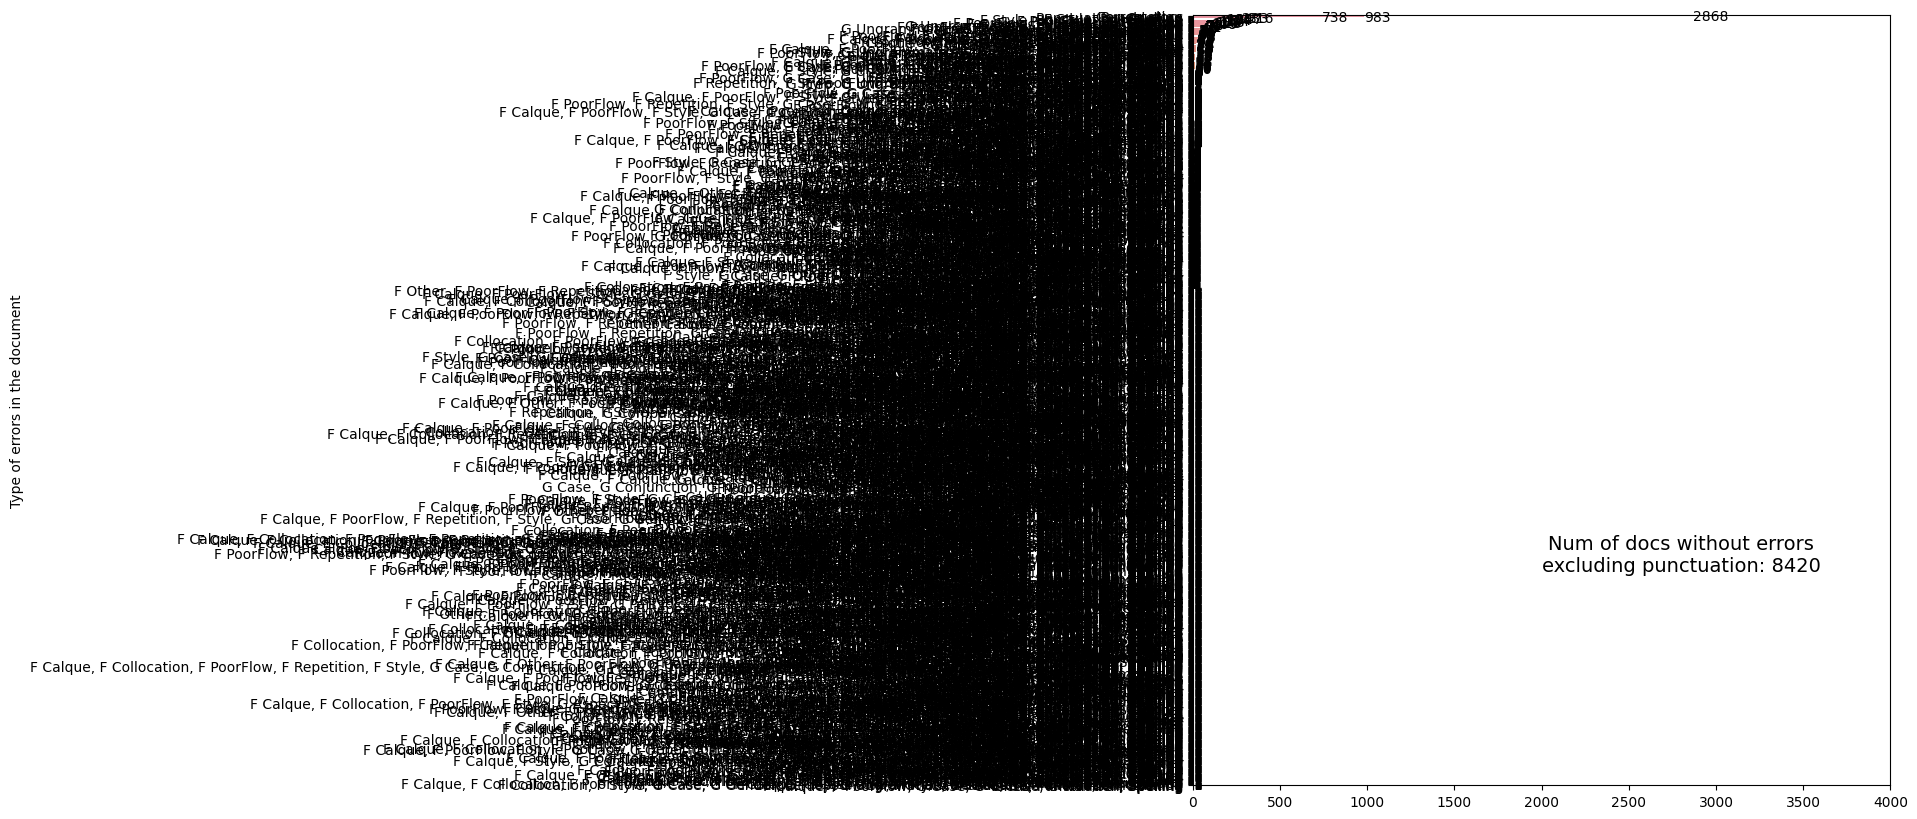

In [ ]:
fig = plt.figure(figsize=(9,10))
ax = sns.barplot(x=err_value_counts.values,
                 y=err_value_counts.index)

# Add labels with respective counts
ax.bar_label(ax.containers[0])

plt.text(0.7, 0.3, f'Num of docs without errors\nexcluding punctuation: {sum(err_value_counts[2:])}', 
             transform=ax.transAxes, ha='center', va='center', size=14)

ax.set_xlim([0, 4000])
plt.ylabel('Type of errors in the document')
plt.show()

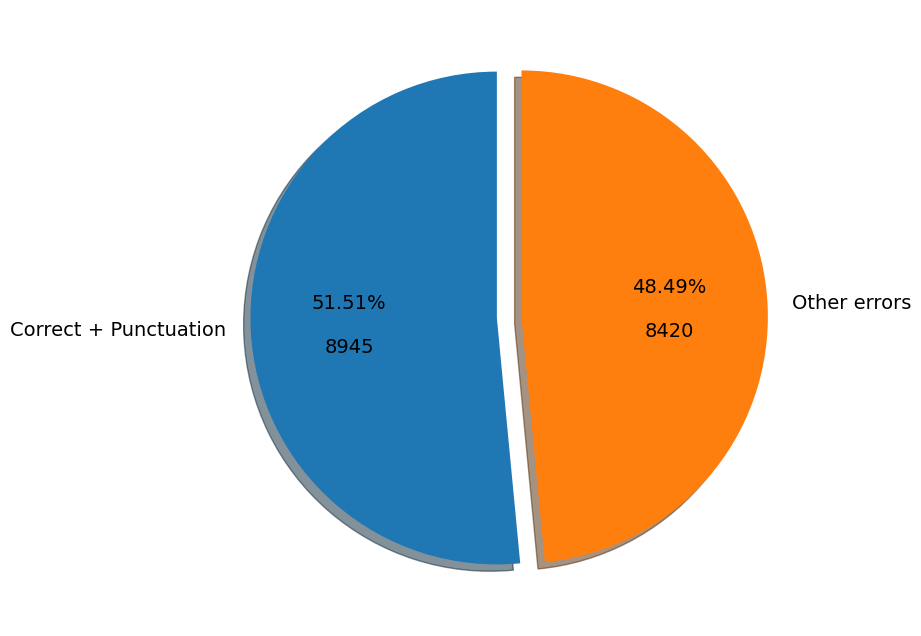

In [ ]:
# Count values of each pie piece
error_count = {
    'Correct + Punctuation': sum(err_value_counts[:2]),
    'Other errors': sum(err_value_counts[2:])
}


def format_pie_labels(x, sum_data):
    '''
    Helper function for formatting pie chart labels
    '''
    absol = int(x / 100 * sum_data)  
    return f'{x:.2f}%\n\n{absol}'


sum_data = np.sum(list(error_count.values()))

# Pie chart ----------------------------------------------------

fig, ax = plt.subplots(figsize=(8,8), nrows=1, ncols=1)

ax.pie(list(error_count.values()),
       autopct = lambda x: format_pie_labels(x, sum_data),
       labels = error_count.keys(),
       shadow = True,
       textprops = dict(fontsize=14),
       startangle = 90,
       explode=[0, 0.1]
         )
                            

fig.show()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

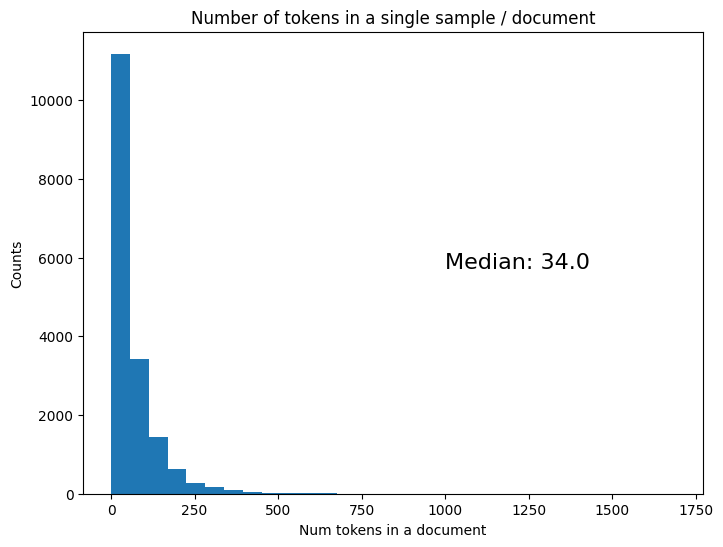

source  \
13449  Актуальність теми дослідження обумовлена тим, ...   
8034   При першій зустрічі з Гаррі Поттером Дамблдор ...   
14996  Я все-таки напишу, скііільки зараз зможу і нас...   
2005   Ключі в руці, сигналізацію ввімкнено - можна р...   
8688   Останнім часом багато читаю про нашу нову полі...   

                                                 cleaned  \
13449  Актуальність теми дослідження зумовлена тим, щ...   
8034   При першій зустрічі з Гаррі Поттером Дамблдор ...   
14996  Я все-таки напишу, скііільки зараз зможу і нас...   
2005   Ключі в руці, сигналізацію ввімкнено — можна р...   
8688   Останнім часом багато читаю про нашу нову полі...   

                                                     err  \
13449  F Calque, F PoorFlow, F Style, G Case, G Compa...   
8034   F Calque, F Collocation, F PoorFlow, F Repetit...   
14996  F Calque, F PoorFlow, F Style, G Case, G Conju...   
2005   F Calque, F Other, F PoorFlow, F Style, Punctu...   
8688   F Calque, F Collocation, F PoorFlow, F Style, ...   

                                                  tokens  num_tokens  
13449  [72631, 354, 123783, 259, 92560, 44880, 8479, ...        1688  
8034   [2492, 10456, 3497, 259, 51966, 13843, 583, 36...        1640  
14996  [2553, 1285, 264, 50467, 310, 112766, 261, 259...        1393  
2005   [259, 162205, 13843, 315, 17820, 3445, 261, 34...        1377  
8688   [259, 140123, 20755, 3748, 637, 29717, 19636, ...        1229

In [ ]:
def get_tokens(df):
    '''Get tokens in the DataFrame with column "cleaned".
    CREATES a column with number of tokens in the corrected sentence, 
    PRINTS histogram with distribution of tokens, 5 rows with greatest number of tokens.
    '''
    tokens, num_tokens = [], []
    for i in range(len(df)):
        t = tokenizer.encode(df.loc[i, 'cleaned'])
        tokens.append(t)
        num_tokens.append(len(t))

    df['tokens'] = tokens
    df['num_tokens'] = num_tokens
    
    # === Histogram ===
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111)
    ax.hist(df.num_tokens, bins=30)
    plt.text(0.7, 0.5, f'Median: {df.num_tokens.median()}', 
             transform=ax.transAxes, ha='center', va='center', size=16)
    plt.title('Number of tokens in a single sample / document')
    plt.ylabel('Counts')
    plt.xlabel('Num tokens in a document')
    plt.show()
    
    display(df.sort_values(by='num_tokens', ascending=False).head())
    
    
get_tokens(df)

In [ ]:
# Check if part of the error pattern is present in any documents
uncorrect = df[df.source.apply(lambda s: 'error_type' in s)]

if len(uncorrect.index) > 0:
    print('Uncorrectly parsed sentences:', uncorrect.index)
    df.drop(index=uncorrect.index, inplace=True)
    df.reset_index(drop=True, inplace=True)

Uncorrectly parsed sentences: Int64Index([1294, 2566, 3357, 16334], dtype='int64')


In [ ]:
additional_split_pattern = r'(?<=.[.?!(\.\.\.)…]) +(?=[А-ЯІ“"])'

In [ ]:
max_tokens = 20

# Select long sentences with big number of tokens
indexes_long_sentenes = df[df['num_tokens'] > max_tokens].index

for i in indexes_long_sentenes:
    # Split the long sentences
    source_list = re.split(additional_split_pattern, df.loc[i, 'source'])
    target_list = re.split(additional_split_pattern, df.loc[i, 'cleaned'])
    
    for s1, s2 in zip(source_list, target_list):
        # Append the splitted sentences to the dataframe
        df = df.append({'source': s1, 'cleaned': s2}, ignore_index=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-30-eef97e87e081>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'source': s1, 'cleaned': s2}, ignore_index=True)
<ipython-input-30-eef97e87e081>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'source': s1, 'cleaned': s2}, ignore_index=True)
<ipython-input-30-eef97e87e081>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'source': s1, 'cleaned': s2}, ignore_index=True)
<ipython-input-30-eef97e87e081>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'source': s1, 'cleaned': s2}, ignore_index=True)
<ipyt

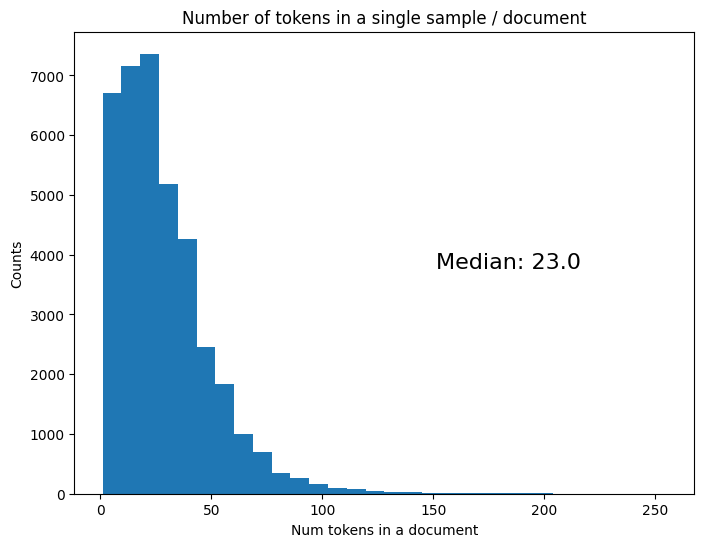

source  \
30715  Вашингтон звинувачує Тегеран у підтримці режим...   
19308  Він або вона має обожнювати кіно, і бути ветер...   
16724  Основні виклики: технічна база як в учителя, т...   
36340  Мені щиро дивно від того,що людина з якою я пр...   
7896   МИТРОПОЛИТ АНДРЕЙ ШЕПТИЦЬКИЙ (29.07.1865-01.11...   

                                                 cleaned  err  \
30715  За весь цей час відбувались певні короткострок...  NaN   
19308  Він або вона має обожнювати кіно, і бути ветер...  NaN   
16724  Основні виклики: технічна база і у вчителя, і ...  NaN   
36340  Мені щиро дивно від того, що людина, з якою я ...  NaN   
7896   МИТРОПОЛИТ АНДРЕЙ ШЕПТИЦЬКИЙ (29.07.1865— 01.1...  NaN   

                                                  tokens  num_tokens  
30715  [1309, 315, 32435, 259, 17468, 3748, 64165, 35...         255  
19308  [32069, 5460, 259, 26100, 259, 12739, 21606, 1...         252  
16724  [259, 58525, 389, 79771, 31766, 267, 259, 6550...         249  
36340  [14152, 389, 259, 12134, 4683, 40600, 616, 166...         226  
7896   [259, 33745, 209811, 213990, 56351, 259, 15919...         218

In [ ]:
# Drop long sentences
df.drop(index=indexes_long_sentenes, inplace=True)
df.reset_index(drop=True, inplace=True)
get_tokens(df)

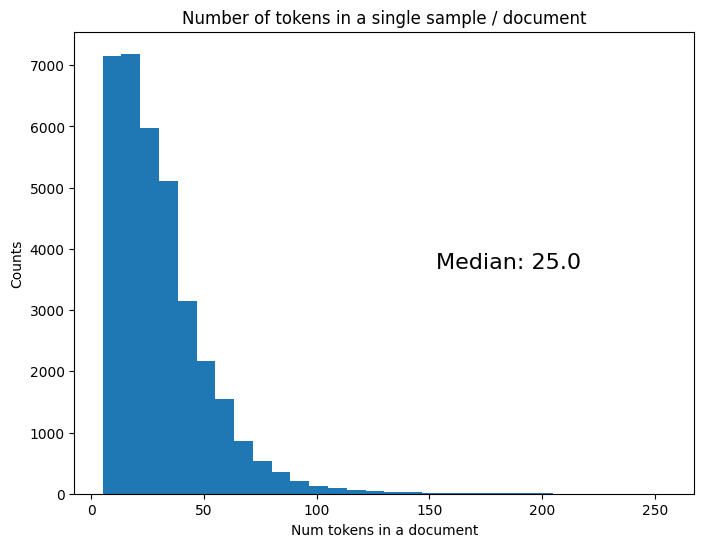

source  \
27765  Вашингтон звинувачує Тегеран у підтримці режим...   
16558  Він або вона має обожнювати кіно, і бути ветер...   
14034  Основні виклики: технічна база як в учителя, т...   
33315  Мені щиро дивно від того,що людина з якою я пр...   
5398   МИТРОПОЛИТ АНДРЕЙ ШЕПТИЦЬКИЙ (29.07.1865-01.11...   

                                                 cleaned  err  \
27765  За весь цей час відбувались певні короткострок...  NaN   
16558  Він або вона має обожнювати кіно, і бути ветер...  NaN   
14034  Основні виклики: технічна база і у вчителя, і ...  NaN   
33315  Мені щиро дивно від того, що людина, з якою я ...  NaN   
5398   МИТРОПОЛИТ АНДРЕЙ ШЕПТИЦЬКИЙ (29.07.1865— 01.1...  NaN   

                                                  tokens  num_tokens  
27765  [1309, 315, 32435, 259, 17468, 3748, 64165, 35...         255  
16558  [32069, 5460, 259, 26100, 259, 12739, 21606, 1...         252  
14034  [259, 58525, 389, 79771, 31766, 267, 259, 6550...         249  
33315  [14152, 389, 259, 12134, 4683, 40600, 616, 166...         226  
5398   [259, 33745, 209811, 213990, 56351, 259, 15919...         218

In [ ]:
# Drop short sentences
df = df[df['num_tokens'] > 4]
df.reset_index(drop=True, inplace=True)

get_tokens(df)

In [ ]:
sorted_df = df.sort_values(by='num_tokens', ascending=False)

for i in range(5):
    print(f'{sorted_df.iloc[i, 0]}\n\n')

Вашингтон звинувачує Тегеран у підтримці режиму Башара Асада в Сирії, розпалюванні громадянської війни в Ємені, підтримці руху Хезболла та, в цілому, тероризму в регіоні й невиконанні 12 «основних вимог» JCPOA [2].


Він або вона має обожнювати кіно, і бути ветераном у відвідуванні кінотеатру, і добре володіти термінологією та жаргоном у галузі кінематографії (наприклад, дальній заявочний план, нахил, операторський кран, закадровий голос, "за кадром", swish pan (вид панорамування), перебивка, великий план тощо), бути обізнаним у проблемах режисерської роботи, монтажу, роботи художника-постановника (вибір об'єктивів, мізасцена, освітлення, звукові ефекти, декорації, грим, саундтрек), знати історію кінематографу, нові тренди, зірок, назви та роки прем'єр фільмів, різноманітні жанри фільмів (наприклад, комедія, мелодрама, хоррор, трилер, екшн, класичний кінематограф, мюзикл, фільм-нуар, документальний фільм, вестерн, неореалізм, експресіонізм, нова хвиля тощо).


Основні виклики: технічна

In [ ]:
corpus = None; del corpus
df = None; del df
sorted_df = None; del sorted_df
gc.collect()

5238

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model = model.to(device)


model.resize_token_embeddings(len(tokenizer))

Embedding(250100, 512)

In [ ]:
num_epochs = 25
batch_size = 4
learning_rate = 0.0001
max_token_length = 50

In [ ]:
tokenizer.tokenize('світ ловив мене та не спіймав')

['▁світ', '▁', 'лови', 'в', '▁мене', '▁та', '▁не', '▁спі', 'й', 'мав']

In [ ]:
class Parallel_Dataset(Dataset):
    '''
    A class to create a custom PyTorch dataset of parallel pairs of sentences (correct - incorrect).
    
    ...
    
    Attributes
    ----------
    partition : str
        partition of the UA-GEC corpus ('all' / 'test' / 'train')
    tokenizer : obj
        instance of a HuggingFace tokenizer
    max_token_length : int
        number of max tokens in a sample
    max_tokens : int
        number of tokens for splitting long sentences
    delete_correct_samples : bool
        delete pairs with sentences without errors if True
    
    Methods
    -------
    _del_rows(indexes)
        Deletes rows and resets indexes in self.df
    _get_df_from_uagec_corpus(partition)
        Create a DataFrame with source and target sentences
    _get_tokens()
        Calculate number of tokens in each sentence, add or rewrite column
    _check_incorrect_parced()
        Check if any of the sentences were incorrectly parsed
    _prepare_data
        Uses previously mentioned methods to prepare data
    __getitem__(index)
        Returns tokenized sentences as arrays of token ids
    '''

    def __init__(self, partition, tokenizer, max_token_length, max_tokens=20, delete_correct_samples=False):
        self.tokenizer = tokenizer
        self.max_token_length = max_token_length
        self.df = None
        
        # Load and preprocess UA-GEC corpus when instatiating an object of a class 
        self._prepare_data(partition, delete_correct_samples, max_tokens)
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        batch = {}
        current_row = self.df.iloc[index]
        input_sentence = current_row['source']
        target_sentence = current_row['cleaned']
        
        inputs = self.tokenizer(input_sentence, 
                                         return_tensors='pt',
                                         padding = 'max_length',
                                         truncation = True,
                                         max_length = self.max_token_length)
        outputs = self.tokenizer(target_sentence, 
                                         return_tensors='pt',
                                         padding = 'max_length',
                                         truncation = True,
                                         max_length = self.max_token_length)
        
        batch["input_ids"] = inputs.input_ids.flatten()
        batch["attention_mask"] = inputs.attention_mask.flatten()
        batch["labels"] = outputs.input_ids.flatten()
       
        return batch
    
  

    def _del_rows(self, indexes):
        '''Deletes rows by given indexes in self.df with index reset.'''
        self.df.drop(index=indexes, inplace=True)
        self.df.reset_index(drop=True, inplace=True) 
        
    
    def _get_df_from_uagec_corpus(self, partition):
        '''Load UA-GEC corpus and create a DataFrame with source and target sentences.'''
        
        # Load UA-GEC corpus
        corpus = Corpus(partition=partition)
        
        source_sentences = []
        cleaned_sentences = []
        errors_in_sentences = []
        
        # Iterate through every document in corpus
        for doc in tqdm(corpus, total=len(corpus), desc='Loading corpus...', colour='#67597a'):
            
            # Convert document to string
            document = str(doc.annotated)
            
            # Split document into chunks by new line
            splitted = [re.sub(r'\n+', ' ', e).strip() for e in re.split(split_pattern, document) if e]

            for sentence in splitted:
                # Replace special symbols and delete excess whitespaces 
                sentence = sentence.replace('\\', ' ')
                sentence = sentence.replace('/', ' ')
                sentence = sentence.strip()
            
                # Copy initial sentence
                clean = sentence
                source_sentence = sentence

                # Find annotated errors in currect sentence / text chunk
                matches = re.finditer(error_pattern, sentence, re.MULTILINE | re.UNICODE | re.VERBOSE)

                errors = []

                for match in matches:
                    # Complete annotation with curly brackets 
                    mistake = match.group(0)

                    # Initial error 
                    source_mistake =  match.group(2)

                    # Suggested correction 
                    correction =  match.group(3)

                    # Error type 
                    err_type = match.group(4)
                    errors.append(err_type)       
                
                    # Replace RegEx special symbols
                    for ss in regex_special_symbols.keys():
                        if ss in mistake:
                            mistake = mistake.replace(ss, regex_special_symbols[ss])
                            correction = correction.replace(ss, regex_special_symbols[ss])
                            source_mistake = source_mistake.replace(ss, regex_special_symbols[ss]) 
                    try:
                        # Replace annotation with correction
                        clean = re.sub(mistake, correction, clean)
                    except:
                        print(sentence, '\n\n', mistake, '\n\n', correction, '\n\n', clean)

                    # Replace annotation with initial mistake
                    source_sentence = re.sub(mistake, source_mistake, source_sentence)

                # Append lists with source sentences with errors, corrected sentences and the respective error types
                source_sentences.append(source_sentence)
                errors_in_sentences.append(set(errors))
                cleaned_sentences.append(clean) 

        self.df = pd.DataFrame({'source': source_sentences,
                                'cleaned': cleaned_sentences,
                                'err': errors_in_sentences}) 
        
        self.df['err'] = self.df.err.apply(lambda x: ', '.join(list(x)))
        
        print('Corpus loaded!')
        
        
    
    def _get_tokens(self):
        '''Create or rewrite column with number of tokens in the source sentence.'''
        num_tokens = []
        num_documents = len(self.df)
        
        # Iterate through every document in the dataframe
        for i in range(num_documents):
            # Tokenize source sentences
            t = self.tokenizer.tokenize(self.df.loc[i, 'cleaned'])
            # Calculate and append number of tokens to list
            num_tokens.append(len(t))
        # Create / rewrite column in dataframe
        self.df['num_tokens'] = num_tokens
        
    
    def _check_incorrect_parced(self):
        '''Check if part of the error pattern is present in any documents'''
        
        uncorrect = self.df[self.df.source.apply(lambda s: 'error_type' in s)]
        num_incorrect = len(uncorrect.index)
        if num_incorrect > 0:
            # Print and remove incorrectly parced sentences
            print('Uncorrectly parsed sentences:', uncorrect.index)
            self._del_rows(uncorrect.index)
     
    # === Main function to preprocess data ===
    
    def _prepare_data(self, partition, delete_correct_samples, max_tokens):
        '''Load and preprocess corpus.'''
        
        # Create a dataframe
        self._get_df_from_uagec_corpus(partition)
        
        # Delete pairs with sentences without errors
        if delete_correct_samples:
            no_errors_index = self.df[self.df.err == ''].index
            #self._del_rows(no_errors_index)

        # Check if any of the sentences were incorrectly parsed
        self._check_incorrect_parced()
        
        # Calculate number of tokens in each sentence
        self._get_tokens()

        # Select long sentences with big number of tokens
        indexes_long_sentenes = self.df[self.df['num_tokens'] > max_tokens].index
        for i in indexes_long_sentenes:
            # Split the long sentences
            source_list = re.split(additional_split_pattern, self.df.loc[i, 'source'])
            target_list = re.split(additional_split_pattern, self.df.loc[i, 'cleaned'])
            # Append splitted source and target sentences to dataframe
            for s1, s2 in zip(source_list, target_list):
                self.df = self.df.append({'source': s1, 'cleaned': s2}, ignore_index=True)
        
        # Delete long sentences splitted previously
        self._del_rows(indexes_long_sentenes)
        
        # Recalculate tokens
        self._get_tokens()
        
        # Remove short sentences
        short_sent_index = self.df[self.df['num_tokens'] < 4].index
        
        self._del_rows(short_sent_index)
        
        print(f'{partition.title()} dataset loaded!')
        print(f'Length of {partition} dataset = {len(self.df)}\n' + '='*80)
        

In [ ]:
# Create test and train datasets by using the corresponding partition of the UA-GEC corpus 
dataset_test = Parallel_Dataset(partition='test', tokenizer=tokenizer, max_token_length=max_token_length, delete_correct_samples=True)
dataset_train = Parallel_Dataset(partition='train', tokenizer=tokenizer, max_token_length=max_token_length, delete_correct_samples=True)

Loading corpus...:   0%|          | 0/332 [00:00<?, ?it/s]

Corpus loaded!
Uncorrectly parsed sentences: Int64Index([234, 600, 706], dtype='int64')


Streaming output truncated to the last 5000 lines.
<ipython-input-38-bdc1b79875d4>:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append({'source': s1, 'cleaned': s2}, ignore_index=True)
<ipython-input-38-bdc1b79875d4>:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append({'source': s1, 'cleaned': s2}, ignore_index=True)
<ipython-input-38-bdc1b79875d4>:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append({'source': s1, 'cleaned': s2}, ignore_index=True)
<ipython-input-38-bdc1b79875d4>:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append({'source': 

Test dataset loaded!
Length of test dataset = 4974


Loading corpus...:   0%|          | 0/1749 [00:00<?, ?it/s]

Corpus loaded!
Uncorrectly parsed sentences: Int64Index([12119], dtype='int64')


Streaming output truncated to the last 5000 lines.
<ipython-input-38-bdc1b79875d4>:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append({'source': s1, 'cleaned': s2}, ignore_index=True)
<ipython-input-38-bdc1b79875d4>:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append({'source': s1, 'cleaned': s2}, ignore_index=True)
<ipython-input-38-bdc1b79875d4>:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append({'source': s1, 'cleaned': s2}, ignore_index=True)
<ipython-input-38-bdc1b79875d4>:208: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.df = self.df.append({'source': 

Train dataset loaded!
Length of train dataset = 29691


In [ ]:
dataset_train.df.tail(30)

source  \
29661  Острів живе туризмом і, звісно, пандемія вдари...   
29662  Цього року ми приїхали відпочивати на Крит, по...   
29663  Але в цей час я не могла перестати думати про ...   
29664  Адже просто перед очима був приклад сім’ї, без...   
29665  Тому дуже захотілося створити невеличку пам’ят...   
29666                    ▪️ Бути терпимішими до помилок.   
29667  Там, за стійкою у готелі, стоїть жива людина, ...   
29668  На неї періодично зриваються туристи чи кричит...   
29669  А ще вона може переживати, що втратить цю сезо...   
29670               А, може, вона просто дуже втомилася.   
29671  І вже кілька днів йде з дому, коли діти ще спл...   
29672                           Тому будьмо терпимішими.   
29673                    Звісно, ситуації бувають різні.   
29674  Але спокійне вирішення претензії — це менше ст...   
29675                                ▪️ Виявляти повагу.   
29676  В  туризмі немає престижної чи непрестижної ро...   
29677  Уявіть, що ви живете у місці, де 90% людей пра...   
29678  Для них це просто робота, яка їх годує, про пр...   
29679  Багато хто має освіту в зовсім іншій сфері, ба...   
29680  Спілкуватися ввічливо, а не “ей, ти, принеси м...   
29681  ▪️ Усміхатися 🙂 Запитайте у працівників на рес...   
29682  Це зовсім не складно, але може покращити людин...   
29683  Чи навіть перекрити всі турботи складного робо...   
29684                     Нарешті хоч одна добра новина.   
29685  Купив колеса, будь-які, то вчи та дотримуйся ПДР.   
29686  Якщо є можливість зробити неправильно, люди зр...   
29687  Особливо, якщо інструмент провокує таке робити...   
29688                   Яким боком московити  нам брати?   
29689       І навіть якщо брати, то Авель теж мав брата.   
29690  Якщо судити по автівці, то де Папа, а де якийс...   

                                                 cleaned  err  num_tokens  
29661  Острів живе туризмом і, звісно, пандемія вдари...  NaN          27  
29662  Цього року ми приїхали відпочивати на Крит, по...  NaN          34  
29663  Але в цей час я не могла перестати думати про ...  NaN          24  
29664  Адже просто перед очима був приклад сім’ї, без...  NaN          66  
29665  Тому дуже захотілося створити невеличку пам’ят...  NaN          24  
29666                    ▪️ Бути терпимішими до помилок.  NaN          13  
29667  Там, за стійкою у готелі, стоїть жива людина, ...  NaN          57  
29668  На неї періодично зриваються туристи чи кричит...  NaN          17  
29669  А ще вона може переживати, що втратить цю сезо...  NaN          49  
29670                А може, вона просто дуже втомилася.  NaN          12  
29671  І вже кілька днів йде з дому, коли діти ще спл...  NaN          35  
29672                           Тому будьмо терпимішими.  NaN          10  
29673                    Звісно, ситуації бувають різні.  NaN          10  
29674  Але спокійне вирішення претензії — це менше ст...  NaN          36  
29675                                ▪️ Виявляти повагу.  NaN           9  
29676  У  туризмі немає престижної чи непрестижної ро...  NaN          16  
29677  Уявіть, що ви живете у місці, де 90% людей пра...  NaN          43  
29678  Для них це просто робота, яка їх годує, про пр...  NaN          26  
29679  Багато хто має освіту в зовсім іншій сфері, ба...  NaN          39  
29680  Спілкуватися ввічливо, а не “гей, ти, принеси ...  NaN          37  
29681  ▪️ Усміхатися 🙂 Запитайте у працівників на рес...  NaN          48  
29682  Це зовсім не складно, але може покращити людин...  NaN          21  
29683  Чи навіть перекрити всі турботи складного робо...  NaN          28  
29684                   Нарешті бодай одна добра новина.  NaN          10  
29685  Купив колеса, будь-які, то вчи та дотримуйся ПДР.  NaN          21  
29686  Якщо є можливість зробити неправильно, люди зр...  NaN          18  
29687  Особливо, якщо інструмент провокує таке робити...  NaN          26  
29688             З якого це дива московити — нам брати?  NaN

In [ ]:
dataset_train.df = dataset_train.df.drop(dataset_train.df.index[14400:])
dataset_train.df.tail(30)

source  \
14370  У руках в неї виявилася серветочка с чимось тя...   
14371  Очі в Ганночки вилізали на лоба, коли вона роз...   
14372  Ганночка до самих очей підносила дорогоцінніст...   
14373  У голові Ганночки зробилася хуртелиця: "Знати ...   
14374                          Бачити нічого не бачу!...   
14375                                     До племінника?   
14376                     Чи розпилити її на шматочки...   
14377                 Камінчики то можна і виковиряти...   
14378  І по одному камінчику: один на Петрівку, інший...   
14379  І - знати нічого не знаю, бачити нічого не бачу!"   
14380  У американському християнському дискурсі існує...   
14381  Це поняття означає надмірний акцент на релігій...   
14382  Іншими словами, коли "церковний" спосіб життя ...   
14383  Здавалося б, в українському контексті таке пон...   
14384  Та от біда – літні люди виросли і формувалися ...   
14385      І зовсім інакше виглядають справи із молоддю.   
14386  Карантин – лекало соціальної відповідальності ...   
14387  Людина, що дотримується рекомендацій рятує не ...   
14388  Та от візити молоді до церкви сьогодні, під ча...   
14389  Джерелом цієї проблеми є нівелювання значення ...   
14390  У свідомості сучасного вірянина сповідь стає "...   
14391  Укупі це дає відчуття "духовного" оптимізму і,...   
14392  Властиво, якщо в церкві на мене чекає справа м...   
14393              Чи ж я захворію від Святого Причастя?   
14394  Зрештою, на зміну радянській людині в церкву п...   
14395  Навіть у самому причасті головним стає не його...   
14396  Десятки тисяч людей по всьому світові моляться...   
14397  Коронавірус поширюється і у церкві, і передаєт...   
14398                        І це говорить про дві речі:   
14399  Або коронавірус – увертюра до кінця світу, яки...   

                                                 cleaned  err  num_tokens  
14370  У руках в неї виявилася серветочка з чимось ва...  NaN          19  
14371  Очі в Ганночки вилізли на лоба, коли вона розг...  NaN          23  
14372  Ганночка до самих очей підносила дорогоцінніст...  NaN          27  
14373  У голові Ганночки зробилася хурделиця: "Знати ...  NaN          23  
14374                          Бачити нічого не бачу!...  NaN           9  
14375                                     До племінника?  NaN           5  
14376                     Чи розпилити її на шматочки...  NaN          11  
14377                 Камінчики то можна і виковиряти...  NaN          13  
14378  І по одному камінчику: один на Петрівку, інший...  NaN          23  
14379  І — знати нічого не знаю, бачити нічого не бачу!"  NaN          20  
14380  В американському християнському дискурсі існує...  NaN          28  
14381  Це поняття означає надмірний акцент на релігій...  NaN          40  
14382  Іншими словами, коли "церковний" спосіб життя ...  NaN          24  
14383  Здавалося б, в українському контексті таке пон...  NaN          44  
14384  Та от біда — літні люди виросли і формувалися ...  NaN          50  
14385      І зовсім інакше виглядають справи із молоддю.  NaN          15  
14386  Карантин — лекало соціальної відповідальності ...  NaN          17  
14387  Людина, що дотримується рекомендацій, рятує не...  NaN          39  
14388  Та от візити молоді до церкви сьогодні, під ча...  NaN          56  
14389  Джерелом цієї проблеми є нівелювання значення ...  NaN          31  
14390  У свідомості сучасного вірянина сповідь стає "...  NaN          40  
14391  Укупі це дає відчуття "духовного" оптимізму і,...  NaN          36  
14392  Властиво, якщо в церкві на мене чекає справа м...  NaN          32  
14393              Чи ж я захворію від Святого Причастя?  NaN          14  
14394  Зрештою, на зміну радянській людині в церкву п...  NaN          62  
14395  Навіть у самому причасті головним стає не його...  NaN          53  
14396  Десятки тисяч людей по всьому світові моляться...  NaN          38  
14397  Коронавірус поширюється і у церкві, і передаєт...  NaN

In [ ]:
dataset_train[0]

{'input_ids': tensor([   259, 129686,    332,   5263,   5460,    359,   2881,   3497,    610,
          48115,    259,  27971,  47289,    354,    456,   9738,    365,      1,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]),
 'labels': tensor([   259, 129686,    332,   5263,   5460,    359,   2881,   3497,    610,
          48115,    259,  27971,  47289,    354,    315,   9738,    365,      1,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,


In [ ]:
# Create instances of the optimizer and the dataloader(s)

dataloader_train = DataLoader(dataset_train, batch_size=batch_size)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

# Total number of training iterations = num_epochs * num_batches
total_steps = num_epochs * len(dataloader_train)

# Num steps during which lr increases linearly from 0 to the initial lr 
n_warmup_steps = int(total_steps * 0.01)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = get_linear_schedule_with_warmup(optimizer, n_warmup_steps, total_steps)

In [ ]:
def train(model, num_epochs, optimizer, dataloader_train, dataloader_val=None, scheduler=None):
    """
    Train a ML model and return its best weights alongside with the loss dictionary.
    """    
    
    history = {
        'loss': [],
        'val_loss': [],
        'smallest_val_loss': (0,0)
    }
    
    n_batches = len(dataloader_train)
    if dataloader_val:
        n_batches_val = len(dataloader_val)
    
    # Copy initial model weights
    best_model_weights = copy.deepcopy(model.state_dict())
    
    smallest_loss = np.inf
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        
        # === Training ===
        
        # Set model in training mode
        model.train()
        
        # Set loss of the current epoch to 0
        epoch_loss_train = 0
       
        # Iterate through batches in train dataloader
        for batch in tqdm(dataloader_train, total=n_batches, desc='Training...'):
            
            input_ids = batch["input_ids"] 
            attention_mask = batch["attention_mask"] 
            labels = batch["labels"] 

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            # Empty gradients
            # (PyTorch accumulates the gradients on subsequent backward passes)
            optimizer.zero_grad()
            
            # Forward pass 
            out = model.forward(input_ids=input_ids, labels=labels, attention_mask=attention_mask)
            
            # Get the mean loss of the batch
            loss = out.loss
            
            # Add average batch loss
            epoch_loss_train += loss.item()
            
            # Calculate gradients (backpropagation)
            loss.backward()
            
            # Update model's weigths
            optimizer.step()
        
            # Update learning weight
            if scheduler is not None:
                scheduler.step()
            
        # Add current epoch loss to history
        epoch_loss_train /= n_batches
        history['loss'].append(epoch_loss_train)         
        
        # === Evaluation ===
        
        if dataloader_val is not None:
            
            epoch_loss_val = 0
            
            # Set model in  model in evaluation
            model.eval()
            
            # Disable gradient calculation
            with torch.no_grad():
                for batch in tqdm(dataloader_val, total=n_batches_val, desc='Performing evaluation...',  colour='#fb5607'):
                    
                    input_ids = batch["input_ids"] 
                    attention_mask = batch["attention_mask"] 
                    labels = batch["labels"] 

                    input_ids = input_ids.to(device)
                    attention_mask = attention_mask.to(device)
                    labels = labels.to(device)
                    
                    out = model.forward(input_ids=input_ids, labels=labels, attention_mask=attention_mask)
                    
                    loss = out.loss
                    
                    epoch_loss_val += loss.item()
            
            epoch_loss_val /= n_batches_val
            history['val_loss'].append(epoch_loss_val)
            
            # If current epoch loss is smaller than the previous one
            # Save current weights of the model, save loss as smallest
            if epoch_loss_val < smallest_loss:
                best_model_wts = copy.deepcopy(model.state_dict())
                smallest_loss = epoch_loss_val
                history['smallest_val_loss'] = (epoch, smallest_loss)
                print('Smallest loss, weights saved!')
        
        print(f'Train loss: {epoch_loss_train} | Val loss: {epoch_loss_val}') if dataloader_val else print(f'Train loss: {epoch_loss_train}')
        print('=' * 80 + '\n')
                   
    # Save best weights, last weights of the model
    # Note: if no validation dataloader is given, initial weights are returned 
    history['best_model_wts'] = best_model_wts
    history['last_model_wts'] = copy.deepcopy(model.state_dict())
    
    # Load best weights and return model 
    if dataloader_val is not None:   
        model.load_state_dict(best_model_wts)
        
    return model, history
      
        
model, history = train(model, num_epochs, optimizer, dataloader_train, dataloader_test, scheduler=scheduler)

Epoch 1/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Smallest loss, weights saved!
Train loss: 9.996301494124863 | Val loss: 0.7629255743343922

Epoch 2/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Smallest loss, weights saved!
Train loss: 1.2318892806602848 | Val loss: 0.6401025076947771

Epoch 3/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Smallest loss, weights saved!
Train loss: 0.6062998819351196 | Val loss: 0.5323378811558556

Epoch 4/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Smallest loss, weights saved!
Train loss: 0.42048757423517397 | Val loss: 0.4545281711815414

Epoch 5/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Smallest loss, weights saved!
Train loss: 0.3433065008148292 | Val loss: 0.42859417529410976

Epoch 6/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Smallest loss, weights saved!
Train loss: 0.30102058760563116 | Val loss: 0.4129004419221978

Epoch 7/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Smallest loss, weights saved!
Train loss: 0.27350551355617225 | Val loss: 0.4057292395006151

Epoch 8/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Smallest loss, weights saved!
Train loss: 0.2529956365917395 | Val loss: 0.4000272114973697

Epoch 9/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Smallest loss, weights saved!
Train loss: 0.23695147529399643 | Val loss: 0.3906160190262962

Epoch 10/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Train loss: 0.22370368813183936 | Val loss: 0.3969639134341574

Epoch 11/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Smallest loss, weights saved!
Train loss: 0.21034498604227944 | Val loss: 0.39020408734155543

Epoch 12/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Train loss: 0.2007957504164531 | Val loss: 0.39407429546243183

Epoch 13/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Train loss: 0.1913570098010435 | Val loss: 0.3944650393013681

Epoch 14/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Train loss: 0.18290155536171773 | Val loss: 0.3996807410512

Epoch 15/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Train loss: 0.17550220064935274 | Val loss: 0.40157133453673743

Epoch 16/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Train loss: 0.17014075228226527 | Val loss: 0.40042892908533345

Epoch 17/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Train loss: 0.16409982202998233 | Val loss: 0.40447240908875093

Epoch 18/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Train loss: 0.15826986092472603 | Val loss: 0.4113293084779137

Epoch 19/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Train loss: 0.15492686385667184 | Val loss: 0.4087288927604947

Epoch 20/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Train loss: 0.15038054941519577 | Val loss: 0.4062458401700479

Epoch 21/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Train loss: 0.146833089618942 | Val loss: 0.4116839472628792

Epoch 22/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Train loss: 0.14390551880639071 | Val loss: 0.4135195444721661

Epoch 23/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Train loss: 0.14231389023266577 | Val loss: 0.41635681518873224

Epoch 24/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Train loss: 0.14043300097733866 | Val loss: 0.4191400850410412

Epoch 25/25


Training...:   0%|          | 0/3600 [00:00<?, ?it/s]

Performing evaluation...:   0%|          | 0/1244 [00:00<?, ?it/s]

Train loss: 0.13918083637914 | Val loss: 0.4177689634413152



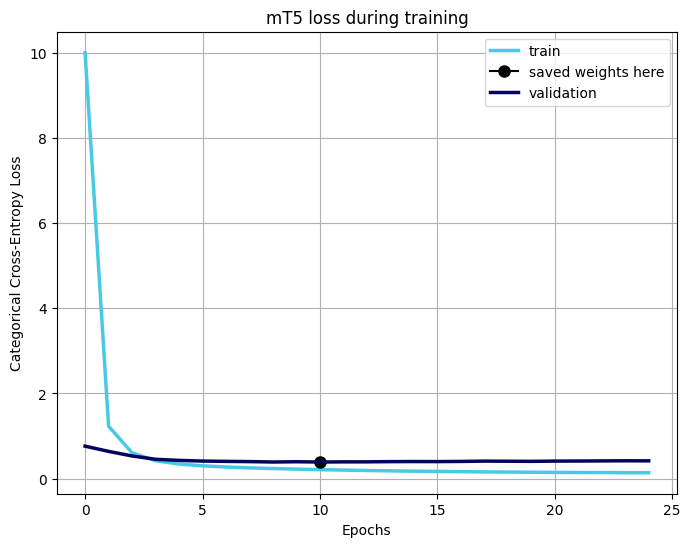

In [ ]:
# Plot training (and validation) loss
plt.figure(figsize=(8,6))
plt.plot(history['loss'], label='train', color='#48cae4', linewidth=2.5)

if len(history['val_loss']) > 0:
    plt.plot(history['smallest_val_loss'][0], history['smallest_val_loss'][1], marker="o", 
             label='saved weights here', markersize=8, color='black')
    plt.plot(history['val_loss'], label='validation', color='#03045e', linewidth=2.5)
    
plt.legend()
plt.title('mT5 loss during training')
plt.ylabel('Categorical Cross-Entropy Loss')
plt.xlabel('Epochs')
plt.grid()
plt.show()

In [ ]:
text = 'я й не думав шо'

# Tokenizer parameters
tokenizer_dict = dict(return_tensors = 'pt',
                      padding = 'max_length',
                      truncation = True,
                      max_length = max_token_length)

In [ ]:
def predict_sequences(text, model, tokenizer, num_return_sequences, tokenizer_kwargs_dict):
    
    # Tokenize input text
    inputs = tokenizer(text, **tokenizer_kwargs_dict)
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)
    
    # Generate model's prediction
    output_ids = model.generate(input_ids=input_ids, 
                                num_beams=10, 
                                num_return_sequences=num_return_sequences,
                                attention_mask=attention_mask
                               )
    
    # Decode model's output 
    output_strings = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    
    # === HTML-markup ===
    
    # Add html-headers
    s1_header = 'Source sentence'
    s2_header = 'Correction suggested by NN'
    
    # Div container for two rows
    html = '''
    <div style="display:flex; 
    flex-direction: row; 
    text-align: justify;
    border-radius: 7px;
    border: 2px dashed #8e9aaf;
    padding: 28px;">
    '''
    
    # Contents of the first, second columns respectively
    col1_html = f'''<div style="margin: 0 1em; width: 50%;"><h3>{s1_header}</h3>'''
    col2_html = f'''<div style="margin: 0 1em; width: 50%;"><h3>{s2_header}</h3>'''
    
    for output_str in output_strings:
        markup_s1, markup_s2 = '', ''
        
        # Use difflib module to find differences in two strings
        seq_matcher = dl.SequenceMatcher(None, text, output_str)
    
        # Iterate through indexes of equal / changed chunks of text
        for tag, i1, i2, j1, j2 in seq_matcher.get_opcodes():
            # Add equal elements without change
            if tag == 'equal':
              markup_s1 += text[i1:i2]
              markup_s2 += output_str[j1:j2]
            # Add changed chunks with html-markup
            else:
              markup_s1 += highlight_text(text[i1:i2], '#ffa8B6', padding='0.2em', margin='0')
              markup_s2 += highlight_text(output_str[j1:j2], '#9df9ef', padding='0.2em', margin='0')
                
        col1_html += f'''<p>{markup_s1}</p>'''
        col2_html += f'''<p>{markup_s2}</p>'''
        
    col1_html += '</div>'
    col2_html += '</div>'
    
    html += col1_html + col2_html + '</div>'
            
    display(HTML(html))



predict_sequences(text, model, tokenizer, 3, tokenizer_dict)

/usr/local/lib/python3.9/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
texts = [
    'я й не думав що лінгвіcтика це легко',
    'Слухай Остап чи не міг би ти купити мені червоний гуаш',
    'пятнадцять',
    'один мудрець вдало підмітив чим більше пізнаєш людей, тим більше починаєш любити тварин',
    'хочу подякувати учасників',
    'водій автобуса сказав пасажирам щоб вони оплати проїзд',
    'вона хотіла би навчатися малювання.',
    'концерт тривав майже півтора години',
    'він дбайливий по відношенню до майна',
    'учора був чудове день',
    'він за професії архітектор',
    'нажал я не знала про це',
    'це сама гірша ситуація',
    'ще б ми стільки прочитали сказала Василина' 
]

model.load_state_dict(history['best_model_wts'])


for text in texts:
    predict_sequences(text, model, tokenizer, 3, tokenizer_dict)

In [ ]:
model.load_state_dict(history['last_model_wts'])

for text in texts:
    predict_sequences(text, model, tokenizer, 3, tokenizer_dict)